# Rapport du TP4 - Clustering
### Duc Hau NGUYEN - Mohammed

Importation des dépendances liées aux TP:

In [2]:
import numpy as np
from glob import glob

# scikit-learn
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN

# plot
import matplotlib.pyplot as plt

In [3]:
from sklearn.utils import check_X_y, check_random_state, safe_indexing, deprecated
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
np.seterr(divide='ignore', invalid='ignore')
def check_number_of_labels(n_labels, n_samples):
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2 "
"to n_samples - 1 (inclusive)" % n_labels)

def davies_bouldin_score(X, labels):
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=np.float)
    for k in range(n_labels):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(
            cluster_k, [centroid]))

    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    score = (intra_dists[:, None] + intra_dists) / centroid_distances
    score[score == np.inf] = np.nan
    return np.mean(np.nanmax(score, axis=1))

## Partie 1

Récupérer les jeux de données

In [10]:
dataset = np.loadtxt('cham-data/t4.8k.dat')
print("Dataset loaded, dimension: ", dataset.shape)

print("L'écart-type de dataset:", np.std(dataset, axis=0))

Dataset loaded, dimension:  (8000, 2)
L'écart-type de dataset: [157.98664751  73.64845164]


**Alternative**: Charger toutes les dataset

In [5]:
files = glob('cham-data/*')
fragments = [np.loadtxt(file, dtype=float) for file in files]
dataset = np.concatenate(fragments)

print("Dataset loaded, dimension: ", dataset.shape)

print("L'écart-type de dataset:", np.std(dataset, axis=0))

Dataset loaded, dimension:  (34000, 2)
L'écart-type de dataset: [197.16266356 114.32723419]


Appliquez la méthode DBSCAN de scikit-learn sur ces données.  

In [11]:
# Apprentissage
clustering = DBSCAN(eps=7).fit(dataset)

# Résultat
labels = clustering.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Nombre de cluster:",n_clusters)

Nombre de cluster: 23


Analysez les résultats obtenus

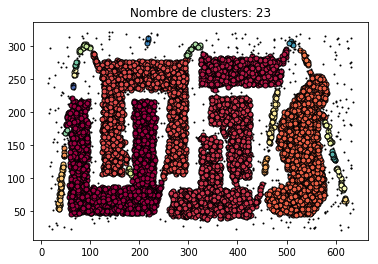

In [12]:
# Color mask for labeled points
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # afficher les données de cluster
    xy = dataset[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5)

    # noises
    xy = dataset[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=1)

plt.title('Nombre de clusters: %d' % n_clusters)
plt.show()

**Bilan de métric**:

In [13]:
def bilan_header(param_name):
    print(param_name, "\t| Nb Cluster \u2192 \t| Silhouette \u2191 \t| Davies Bouldin \u2193")
    print("===========================================================")
    
def bilan(param_val, dataset, cluster): 
    
    silhouette = metrics.silhouette_score(dataset, cluster, metric='euclidean')
    davies_bouldin = davies_bouldin_score(dataset,cluster)
    
    print(
        param_val, "\t|",
        len(set(labels)) - (1 if -1 in labels else 0), "\t\t|", 
        "%.4f" % silhouette, "\t|",
        "%.2f" % davies_bouldin
         )

Choix de `epsilon`

In [14]:
bilan_header("eps")
for eps in range(1,24,2):
    clustering = DBSCAN(
        metric = 'euclidean',
        eps=eps,
        min_samples = 5
    ).fit(dataset)
    labels = clustering.labels_
    bilan(eps, dataset, labels)

eps 	| Nb Cluster → 	| Silhouette ↑ 	| Davies Bouldin ↓
1 	| 1 		| -0.0320 	| 0.85
3 	| 466 		| -0.2249 	| 1.41
5 	| 61 		| -0.4071 	| 3.44
7 	| 23 		| -0.2279 	| 1.58
9 	| 8 		| -0.2534 	| 1.99
11 	| 5 		| -0.3487 	| 2.76
13 	| 4 		| -0.2438 	| 3.06
15 	| 5 		| -0.3066 	| 2.95
17 	| 4 		| -0.1621 	| 3.37
19 	| 6 		| -0.2321 	| 1.47
21 	| 2 		| 0.2057 	| 3.28
23 	| 1 		| 0.3252 	| 9.84


Choix de `min_samples`

In [15]:
bilan_header("min_samp")
for min_samples in range(1,24,2):
    clustering = DBSCAN(
        metric = 'euclidean',
        eps=7, 
        min_samples=min_samples
    ).fit(dataset)
    labels = clustering.labels_
    bilan(min_samples, dataset, labels)
    

min_samp 	| Nb Cluster → 	| Silhouette ↑ 	| Davies Bouldin ↓
1 	| 231 		| -0.6773 	| 0.83
3 	| 30 		| -0.3454 	| 1.43
5 	| 23 		| -0.2279 	| 1.58
7 	| 26 		| -0.2045 	| 1.85
9 	| 20 		| -0.1739 	| 1.71
11 	| 15 		| -0.1201 	| 2.40
13 	| 16 		| -0.0478 	| 2.52
15 	| 36 		| -0.1151 	| 1.87
17 	| 68 		| -0.1217 	| 1.67
19 	| 95 		| -0.1536 	| 1.60
21 	| 77 		| -0.3391 	| 1.41
23 	| 49 		| -0.5219 	| 1.47


## Partie 2
### Algorithme SNN

In [1]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import numpy as np

In [2]:
dataset = np.loadtxt('cham-data/t4.8k.dat')

Paramètre

In [5]:
X = dataset
k = 10
seuil = 200

* Construct similarity mattrix

(save in file to avoid learn time)

In [6]:
similarity_graph = kneighbors_graph(
    X, 
    n_neighbors = X.shape[0] - 1,
    mode='distance', 
    metric='euclidean',
     p=2) # n x n

similarity_matrix = similarity_graph.toarray()
similarity_matrix = 1 / (1 + similarity_matrix)
np.save('similarity_matrix', similarity_matrix)

**(check point)**

In [7]:
similarity_matrix = np.load('similarity_matrix.npy')
print("similarity_matrix loaded, dimension",similarity_matrix.shape)

similarity_matrix loaded, dimension (8000, 8000)


* Sparsify the similarity matrix using k-nn sparsification

In [8]:
neigh = NearestNeighbors(n_neighbors = k, n_jobs=-1)
neigh.fit(similarity_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=10, p=2, radius=1.0)

(save in file to avoid learn time)

In [9]:
k_neighbor_indices = neigh.kneighbors(return_distance = False)
np.save('k_neighbor_indices', k_neighbor_indices)

**(check point)**

In [10]:
k_neighbor_indices = np.load('k_neighbor_indices.npy')
print("k_neighbor_indices loaded, dimension",k_neighbor_indices.shape)

k_neighbor_indices loaded, dimension (8000, 10)


In [11]:
from time import time

t_before = time()

linking_matrix = np.zeros(similarity_matrix.shape)
linking_matrix[np.arange(similarity_matrix.shape[1])[:, None], k_neighbor_indices] = 1
np.save('linking_matrix', linking_matrix)

t_after = time()

print(t_after - t_before)

2.1685614585876465


In [6]:
# Verify if we have sum = k at every line
np.sum(linking_matrix, axis=1)

array([10., 10., 10., ..., 10., 10., 10.])

**(check point)**

In [ ]:
linking_matrix = np.load('linking_matrix.npy')

* For every point in the graph, calculate the total strength of links coming out of the point. (Steps 1-4 are identical to the Jarvis – Patrick scheme.) 

**Testing**:

In [39]:
kth = 3
m = np.matrix([[1,2,3,7,8,1],[6,4,5,7,6,15]])
idx = np.argpartition(m, kth=kth)
m[np.arange(m.shape[0])[:, None], idx[:, :kth]] = 0

print('top ' , kth , ' =', top)
print('snn = ', m)

top  3  = [[5157 4610 6609 ... 2707 2452 1377]
 [6366 6797 5340 ... 2451  880  714]
 [5489 5949 6233 ... 4982 1857 1762]
 ...
 [6616 7107 6469 ... 2051 1820 1801]
 [6493 5057 7051 ... 2983 2966 2222]
 [6227 7503 3923 ... 2511 2212 1336]]
snn =  [[ 0  0  3  7  8  0]
 [ 6  0  0  7  0 15]]


In [41]:
print('test axis 1 =', np.sum(m, axis=1))
print('test axis 0 =', np.sum(m, axis=0))

test axis 1 = [[18]
 [28]]
test axis 0 = [[ 6  0  3 14  8 15]]
